# RFM Analysis
![](https://retainup.co/wp-content/uploads/2021/07/rfm-analysis-1024x550.png)

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime as dt
import jdatetime as jd
from loguru import logger

from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PowerTransformer

from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 72
plt.style.use('ggplot')
pd.options.display.float_format = '{:.0f}'.format
np.random.seed(1)
np.set_printoptions(precision=2, linewidth=100)
sns.set_context('notebook')
jd.set_locale('en')

In [3]:
revenue = pd.read_csv('data/Dataset.csv', index_col=0)

## EDA


In [4]:
def summary_statistic(df) -> pd.DataFrame:

        """
        Summary statistic of the dataset
        input: dataframe
        output: it will return a dataframe with summary statistic
        """

        feature_describe = df.describe().T.reset_index().rename(
                               columns={'index':'feature'}).drop(columns='count')

        feature_info = pd.concat([df.dtypes,
                                  df.nunique(),
                                  df.isna().sum(),
                                  df.count()], axis=1,
                    keys=['dtype', 'num_unique', 'num_Nan', 'count']).reset_index().rename(columns={'index':'feature'})

        summary_statistic_result = feature_info.merge(feature_describe, how='left', on='feature')

        return summary_statistic_result

In [5]:
summary_statistic(revenue)

,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,261960,7169337,4957141,465132,3267469,6663396,11227062,46549548
1,OrderID,int64,261960,0,261960,45264897,6121027,32930756,40061748,44792436,50045929,58853188
2,Date,int64,396,0,261960,20193661,4238,20190321,20190821,20191109,20200115,20200419
3,Revenue,int64,3314,0,261960,6110,5647,106,2451,5100,7960,175200


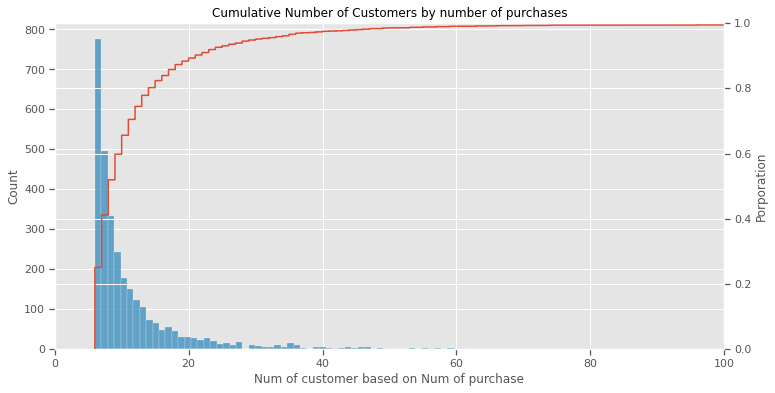

In [6]:
fig, ax1 = plt.subplots()
ax1.set_title('Cumulative Number of Customers by number of purchases')
ax1.set_xlabel('Num of customer based on Num of purchase')
ax1.set_ylabel('Count')
sns.histplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax1)
ax2 = ax1.twinx()
ax2.set_ylabel('Porporation')
sns.ecdfplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax2)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
plt.show()

In [7]:
for index, row in revenue.iterrows():
    assert len(str(row['Date'])) == 8


### Date feature is surely in need for parsing
both to Jalali datetime and Gregory datetime

In [8]:
def convert_gregorian_persian(df, date_col, format_date):
    '''
    convert gregorian date to Jalali date
    input: dataframe, date column name, date format
    output: dataframe with Jalali date, Jalali Months, Jalali weekdays
    '''

    df['JdDate'] = [jd.date.fromgregorian(date=dt.datetime.strptime(str(i), str(format_date))) for i in df[date_col]]
    df['GDate'] = [dt.datetime.strptime(str(i), str(format_date)) for i in df[date_col]]
    df['GDate'] = [dt.datetime.date(i) for i in df['GDate']]
    df['GDate'] = df['GDate'].astype('datetime64')
    df['JdMonth'] = [jd.datetime.jmonth_short(i) for i in df['JdDate']]
    df['JdWeekday'] = [jd.datetime.jweekday_short(i) for i in df['JdDate']]
    
    return df

In [9]:
revenue = convert_gregorian_persian(revenue,'Date','%Y%m%d') #parse date to jalali

In [10]:
logger.info(
    f'\n last Gregory Date = {revenue.GDate.max()}, \n last Jalali date = {str(revenue.JdDate.max())}')

2022-04-11 06:28:46.371 | INFO     | __main__:<cell line: 1>:1 - 
 last Gregory Date = 2020-04-19 00:00:00, 
 last Jalali date = 1399-01-31


let's see if we can see the disturbution of Revenue

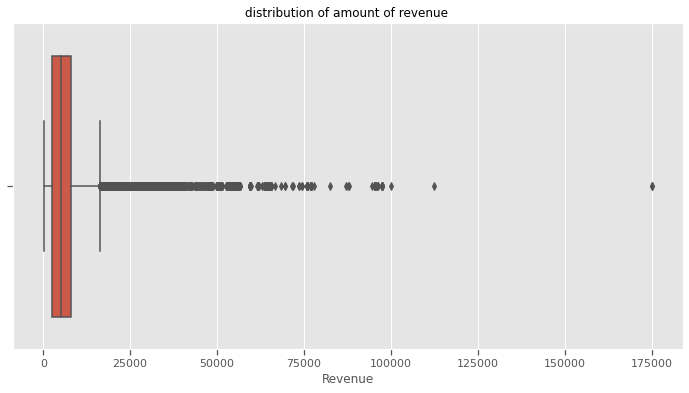

In [27]:
plt.title('Revenue ')
sns.boxplot(revenue.Revenue,)
plt.show()

most of our variable follow the pareto disturbution, intresting.


## task 1
1. Average Order Value, Average Frequency, total revenue in each month of 1398. (Based on Persian calendar)

In [13]:
avg_order_val = np.mean(revenue.groupby('OrderID')['Revenue'].mean()) #Average Order Value
avg_freq = np.mean(revenue.groupby('CustomerID')['OrderID'].count()) #Average Frequency

logger.info(f'\n Average Order Value = {avg_order_val: .2f} \n Average Frequency = {avg_freq: .2f}')

2022-04-11 06:31:28.268 | INFO     | __main__:<cell line: 4>:4 - 
 Average Order Value =  6109.57 
 Average Frequency =  1.46


In [14]:
revehnue1398 = revenue[revenue['JdDate']< jd.date(1399, 1, 1)]
logger.info('\n AVG Revenue Per Month in 1388')
summary98 = pd.concat([revehnue1398.groupby(pd.Grouper(key="JdMonth"), as_index=False)\
                      .agg({'Revenue': 'mean','OrderID': 'count', 'CustomerID': 'nunique'})\
                      .rename(columns=
                                    {'Revenue': 'Avg_Revenue' ,
                                    'OrderID': 'Num_Order',
                                    'CustomerID': 'Num_Customer'}),
                       revehnue1398.groupby(pd.Grouper(key="JdMonth"), as_index=False)\
                                            .agg({'Revenue': 'sum'})\
                                                .rename(columns=
                                                {'Revenue': 'Total_Revenue'})\
                                                                .drop(columns='JdMonth')],axis=1)


summary98

2022-04-11 06:31:37.385 | INFO     | __main__:<cell line: 2>:2 - 
 AVG Revenue Per Month in 1388


,JdMonth,Avg_Revenue,Num_Order,Num_Customer,Total_Revenue
0,Far,5983,3279,2789,19618499
1,Ord,6811,3503,3064,23860379
2,Kho,6354,14380,12768,91363493
3,Tir,6615,16228,14122,107350424
4,Mor,5111,28663,24708,146502637
5,Sha,5603,18630,16603,104375481
6,Meh,5642,26699,22541,150623504
7,Aba,5507,33233,28594,183010916
8,Aza,5821,30989,27344,180390183
9,Dey,6659,26642,23048,177407408


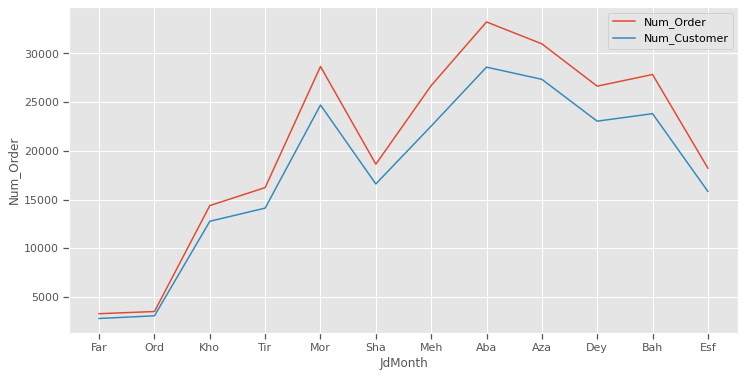

In [16]:
for ind, x in enumerate(summary98.columns[2:-1]):
    # plt.subplot(3,1,ind+1)
    sns.lineplot(data=summary98, x='JdMonth', y=x, label=x)
    # plt.tight_layout()
plt.legend()
plt.show()

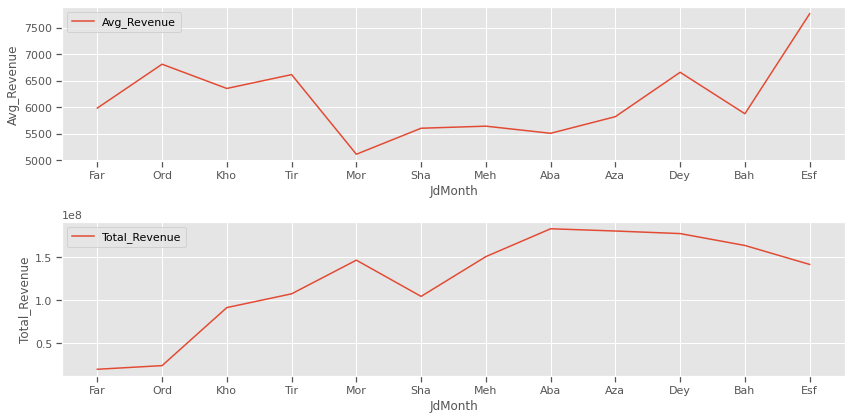

In [29]:
for ind, x in enumerate(summary98.columns[1::3]):
    plt.subplot(2,1,ind+1)
    sns.lineplot(data=summary98, x='JdMonth', y=x, label=x)
    plt.tight_layout()
plt.legend()
plt.show()

## Task 2
Aban 98 had the best results out of total revenue and number of customers

In [68]:
# style.applymap(lambda v:'color:red;' if v is True, props='color:red;')\
# .applymap(lambda v:'color:red;' if v is True else None)

pd.concat([summary98.JdMonth, 
           summary98[summary98==summary98.max(numeric_only=True)].drop(columns='JdMonth')],
           axis=1)



,JdMonth,Avg_Revenue,Num_Order,Num_Customer,Total_Revenue
0,Far,NaN,NaN,NaN,NaN
1,Ord,NaN,NaN,NaN,NaN
2,Kho,NaN,NaN,NaN,NaN
3,Tir,NaN,NaN,NaN,NaN
4,Mor,NaN,NaN,NaN,NaN
5,Sha,NaN,NaN,NaN,NaN
6,Meh,NaN,NaN,NaN,NaN
7,Aba,NaN,33233,28594,183010916
8,Aza,NaN,NaN,NaN,NaN
9,Dey,NaN,NaN,NaN,NaN


In [69]:
# rev_agg = revenue.groupby(pd.Grouper(key='GDate', freq='M'))[['Revenue']]
# rev_agg_dict = dict(rev_sum = rev_agg.sum(), rev_mean = rev_agg.mean(), rev_median = rev_agg.median())
# _ = 1
# for k, v in rev_agg_dict.items():
#     # print(v)
#     # break
#     plt.subplot(3,1,_)
#     plt.title(k)
#     sns.lineplot(x=v.index, y=v.Revenue)
#     _ += 1
# plt.tight_layout()
# plt.show()


In [70]:
LASTGDATE = revenue.GDate.max()
LASTJDATE = revenue.JdDate.max()

let's creat Recency, Frequency, Monitize(both on avg and total)

In [163]:
recency = revenue.groupby(['CustomerID'],as_index=False)['JdDate'].max()\
                 .rename(columns={'JdDate': 'LastPurchaseDate'})
recency['Recency'] = recency.LastPurchaseDate.apply(lambda x:(LASTJDATE - x).days)


In [164]:
recency.head()

,CustomerID,LastPurchaseDate,Recency
0,465132,1398-09-09,141
1,465164,1398-12-09,51
2,465198,1399-01-25,6
3,465204,1398-08-12,168
4,465211,1398-11-02,88


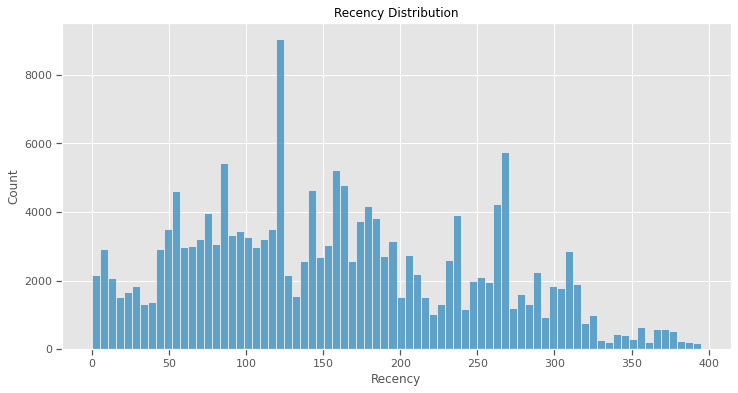

In [165]:
plt.title('Recency Distribution')
sns.histplot(recency.Recency)
plt.show()

In [166]:
freq_mon = revenue.groupby('CustomerID', as_index=False)\
                        .agg({'OrderID': 'count',
                        'Revenue': 'sum'})\
                        .rename(columns={'OrderID' :'Frequency',
                           'Revenue':'Monetary'})

In [167]:
freq_mon.head()

,CustomerID,Frequency,Monetary
0,465132,1,7302
1,465164,1,578
2,465198,1,5688
3,465204,1,1464
4,465211,1,4760


In [76]:
sum([1 if i >= 8 else 0 for i in freq_mon.Frequency]) / len(freq_mon) * 100


1.0129118432769368

7 and more than 7 frequency for our customers is barely possible ~= (1 % of freq). hence we might as well join them togheter. this will results a better model.

<AxesSubplot:xlabel='Frequency', ylabel='count'>

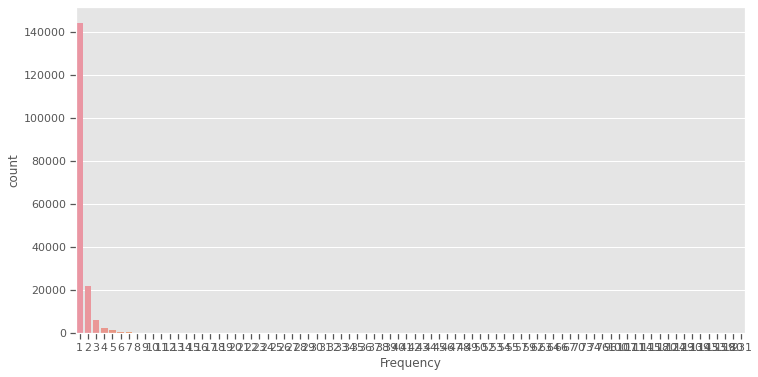

In [77]:
sns.countplot(freq_mon.Frequency)


In [78]:
# freq_mon['Frequency'] = freq_mon.Frequency.apply(lambda x: 7 if x >= 7 else x)

pareto again :)

<AxesSubplot:xlabel='Monetary'>

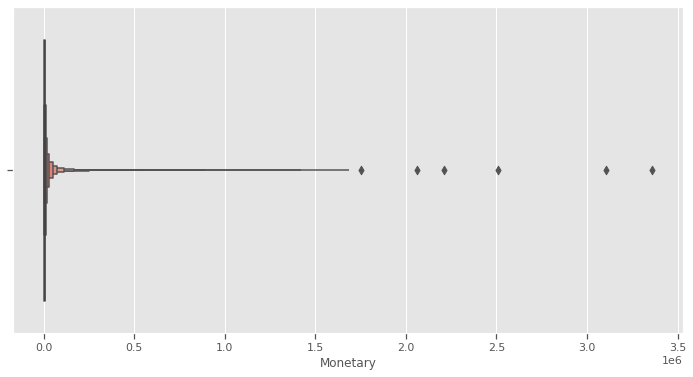

In [79]:
sns.boxenplot(freq_mon.Monetary)

In [168]:
rfm_df = recency.merge(freq_mon,on='CustomerID').drop(columns='LastPurchaseDate')


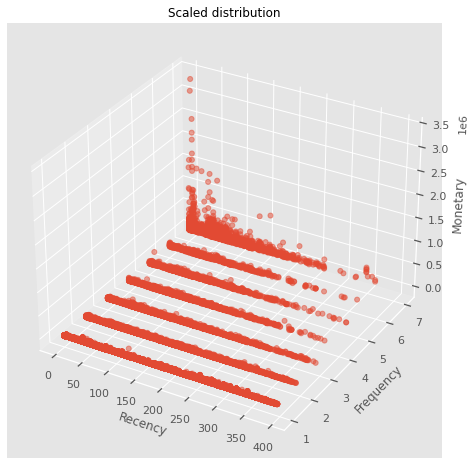

In [147]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_df.Recency, rfm_df.Frequency, 
    zs=rfm_df.Monetary, zdir='z', s=25, depthshade=True, alpha=0.5)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Scaled distribution')
plt.grid()
plt.show()

In [81]:
logger.info(f'Data shape: {rfm_df.shape}')
summary_statistic(rfm_df)

2022-04-11 07:16:36.906 | INFO     | __main__:<cell line: 1>:1 - Data shape: (179680, 4)


,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,179680,7606196,5001455,465132,3536368,7100330,11658242,46549548
1,Recency,int64,396,0,179680,158,90,0,85,150,232,395
2,Frequency,int64,7,0,179680,1,1,1,1,1,1,7
3,Monetary,int64,16962,0,179680,8907,25864,106,2899,5467,9754,3360683


## Clustering

In [82]:
def check_skew(df_skew, column):
    '''
    Check skew of a column in a dataframe
    '''
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], bins=50)
    return logger.info(f"\n {column}'s: Skew: {skew}, : {skewtest} \n")


2022-04-11 07:16:55.907 | INFO     | __main__:check_skew:6 - 
 Recency's: Skew: 0.32064945876314715, : SkewtestResult(statistic=54.15561530881222, pvalue=0.0) 

2022-04-11 07:16:57.035 | INFO     | __main__:check_skew:6 - 
 Frequency's: Skew: 3.7811647640921766, : SkewtestResult(statistic=316.1549177800153, pvalue=0.0) 

2022-04-11 07:16:58.004 | INFO     | __main__:check_skew:6 - 
 Monetary's: Skew: 50.91426917719234, : SkewtestResult(statistic=681.9671668363789, pvalue=0.0) 



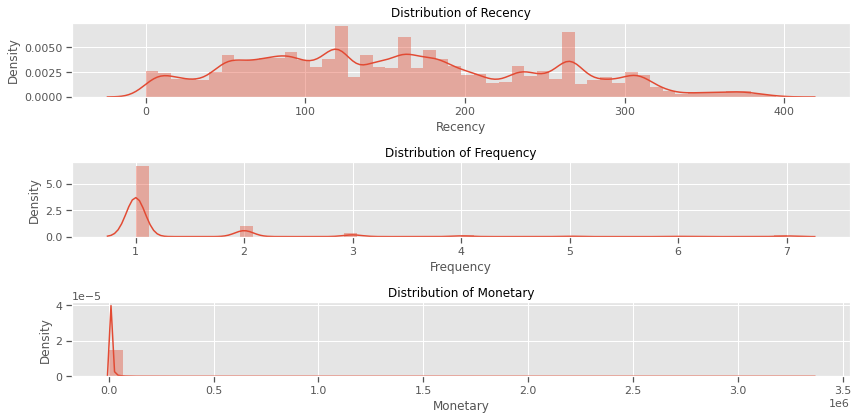

In [83]:
# 
for ind, i in enumerate(rfm_df.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_df, i)
plt.tight_layout()
plt.show()

Obviously, we have to deal with this heavy skewness, and data has extreme outliers. I believe logarithmic scaling for Frequency and Monetary features and winsorizing and standard scaling for all, makes sense.


In [85]:
rfm_log = pd.concat([rfm_df[['CustomerID', 'Recency']], np.log(rfm_df[['Frequency', 'Monetary']])], axis=1)


In [86]:
summary_statistic(rfm_log)

,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,179680,7606196,5001455,465132,3536368,7100330,11658242,46549548
1,Recency,int64,396,0,179680,158,90,0,85,150,232,395
2,Frequency,float64,7,0,179680,0,0,0,0,0,0,2
3,Monetary,float64,16962,0,179680,9,1,5,8,9,9,15


2022-04-11 07:17:19.190 | INFO     | __main__:check_skew:6 - 
 Recency's: Skew: 0.32064945876314715, : SkewtestResult(statistic=54.15561530881222, pvalue=0.0) 

2022-04-11 07:17:20.102 | INFO     | __main__:check_skew:6 - 
 Frequency's: Skew: 2.321231674303311, : SkewtestResult(statistic=249.76700472478717, pvalue=0.0) 

2022-04-11 07:17:20.937 | INFO     | __main__:check_skew:6 - 
 Monetary's: Skew: -0.3747150407190465, : SkewtestResult(statistic=-62.763502952820964, pvalue=0.0) 



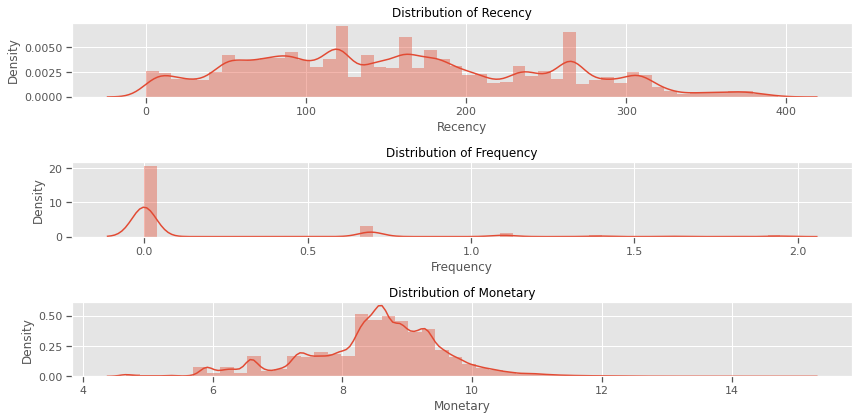

In [87]:
for ind, i in enumerate(rfm_log.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_log, i)
plt.tight_layout()
plt.show()

still too much skewness, let's use power Trasnformer

In [169]:
pt = PowerTransformer(method='yeo-johnson', standardize=True,) 

skl_yeojohnson = pt.fit(rfm_df)

#Lets get the Lambdas that were found
logger.info(f' Lambdas :{skl_yeojohnson.lambdas_}')

calc_lambdas = skl_yeojohnson.lambdas_

#Transform the data 
skl_yeojohnson = pt.transform(rfm_df)

#Pass the transformed data into a new dataframe 
rfm_xt = pd.DataFrame(data=skl_yeojohnson, columns=rfm_df.columns)

2022-04-11 09:22:09.053 | INFO     | __main__:<cell line: 6>:6 -  Lambdas :[ 0.53  0.64 -7.14  0.08]


2022-04-11 09:22:14.593 | INFO     | __main__:check_skew:6 - 
 Recency's: Skew: -0.14400889811927017, : SkewtestResult(statistic=-24.794511907258524, pvalue=1.0274124318961074e-135) 

2022-04-11 09:22:15.334 | INFO     | __main__:check_skew:6 - 
 Frequency's: Skew: 1.5267390918593293, : SkewtestResult(statistic=195.54814262866296, pvalue=0.0) 

2022-04-11 09:22:16.178 | INFO     | __main__:check_skew:6 - 
 Monetary's: Skew: 0.03653997137818537, : SkewtestResult(statistic=6.321435819915521, pvalue=2.5914400701924073e-10) 



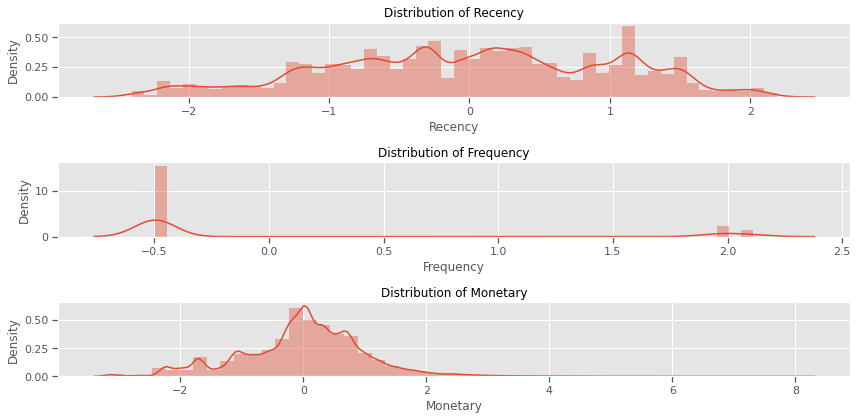

In [170]:
for ind, i in enumerate(rfm_xt.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_xt, i)
plt.tight_layout()
plt.show()

In [171]:
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_xt)[:,1:]


2022-04-11 09:22:59.454 | INFO     | __main__:<cell line: 1>:9 - 
 0's: Skew: -0.1440088981192702, : SkewtestResult(statistic=-24.794511907258546, pvalue=1.0274124318954637e-135) 

2022-04-11 09:23:00.169 | INFO     | __main__:<cell line: 1>:9 - 
 1's: Skew: 1.5267390918593293, : SkewtestResult(statistic=195.54814262866296, pvalue=0.0) 

2022-04-11 09:23:00.981 | INFO     | __main__:<cell line: 1>:9 - 
 2's: Skew: 0.03653997137818537, : SkewtestResult(statistic=6.321435819915521, pvalue=2.5914400701924073e-10) 



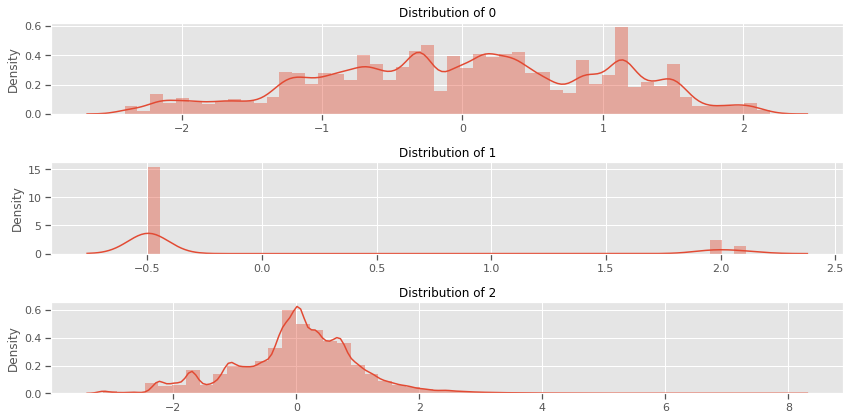

In [173]:
for i in range(3):
    plt.subplot(3,1, i+1)
    # check_skew(rfm_log, i)
    # check_skew(scaler.fit_transform(rfm_df),)
    skew = stats.skew(scaled_rfm[:,i])
    skewtest = stats.skewtest(scaled_rfm[:,i])
    plt.title(f'Distribution of {i}')
    sns.distplot(scaled_rfm[:,i])
    logger.info(f"\n {i}'s: Skew: {skew}, : {skewtest} \n")
plt.tight_layout()
plt.show()



In [91]:
rfm_scaled = pd.DataFrame(scaled_rfm, columns=rfm_log.columns[1:])

logger.info(f'Data shape: {rfm_scaled.shape}')
summary_statistic(rfm_scaled)

2022-04-11 07:18:08.139 | INFO     | __main__:<cell line: 3>:3 - Data shape: (179680, 3)


,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,Recency,float64,396,0,179680,0,1,-2,-1,-0,1,3
1,Frequency,float64,7,0,179680,-0,1,-0,-0,-0,-0,4
2,Monetary,float64,16962,0,179680,-0,1,-4,-0,0,1,6


In [56]:
# rfm_scaled.head()

In [174]:
K = range(1,10) 
def get_distortions(df): 
    '''
    Calculate the distortions for each feature in the dataset
    input: scaled data
    output: distortions - list of distortions for each feature
    output: inertia - inertia of the resulting clusters
    '''
    distortions = [] 
    inertias = [] 
    for k in K: 
        kmeanModel = KMeans(n_clusters=k).fit(df) 
        kmeanModel.fit(df) 
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 
                                 'euclidean'), axis=1)) / df.shape[0]) 
        inertias.append(kmeanModel.inertia_) 
    return distortions, inertias, #kmeanModel.cluster_centers_, kmeanModel.labels_
distortions, inertias = get_distortions(rfm_scaled)

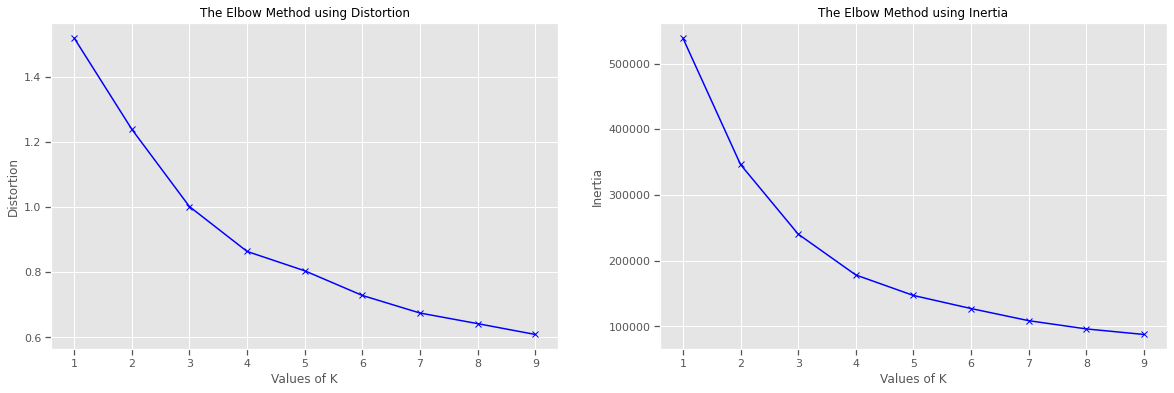

In [175]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 

plt.subplot(1,2,2)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia')
plt.show() 

In [209]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    ''''
    input: scaled data
    input: clusters number
    input: original data
    output: dataframe with cluster labels
    '''
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 42)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_new.Recency, df_new.Frequency, zs=df_new.Monetary, 
                c=df_new.Cluster, zdir='z', s=25, depthshade=True, alpha=0.5)
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.set_title(f'{clusters_number} cluster distribution')
    plt.tight_layout()
    plt.grid()
    plt.show()
    return df_new

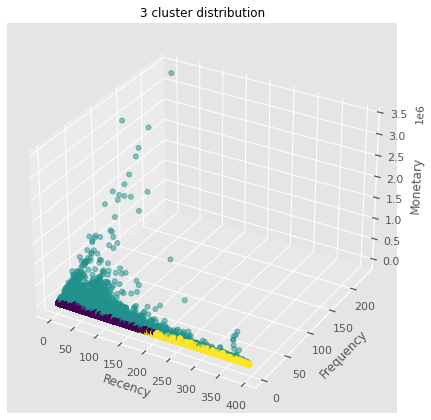

In [211]:

df_rfm_k3 = kmeans(rfm_scaled, 3, rfm_df)


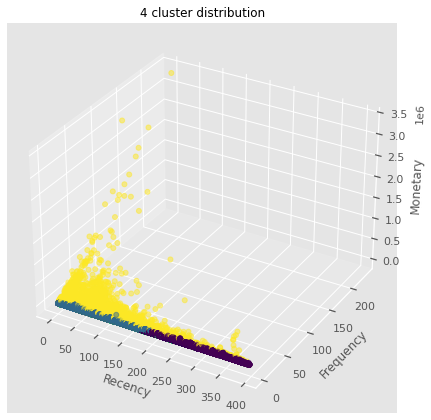

In [212]:
df_rfm_k4 = kmeans(rfm_scaled, 4, rfm_df)



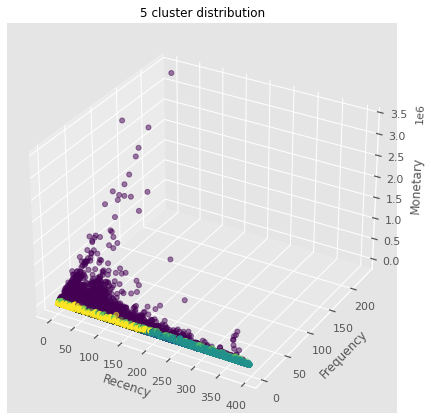

In [213]:
df_rfm_k5 = kmeans(rfm_scaled, 5, rfm_df)

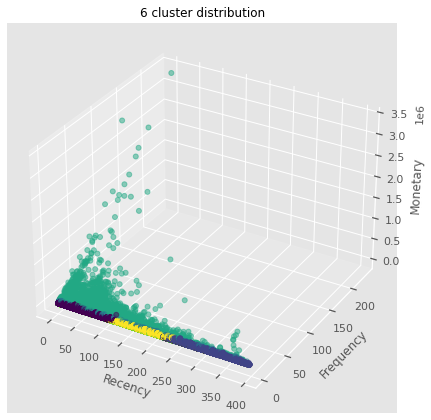

In [214]:
df_rfm_k6 = kmeans(rfm_scaled, 6, rfm_df)

In [192]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=rfm_df.index, 
                                       columns=rfm_df.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return 

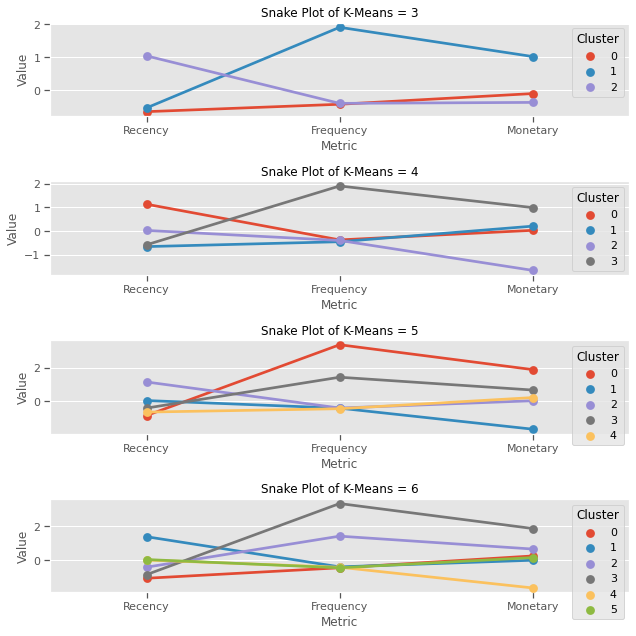

In [201]:
plt.figure(figsize=(9, 9))

plt.subplot(4, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(rfm_scaled, df_rfm_k3, rfm_df)

plt.subplot(4, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(rfm_scaled, df_rfm_k4, rfm_df)

plt.subplot(4, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(rfm_scaled, df_rfm_k5, rfm_df)

plt.subplot(4, 1, 4)
plt.title('Snake Plot of K-Means = 6')
snake_plot(rfm_scaled, df_rfm_k6, rfm_df)

plt.tight_layout()
plt.show()

From the 3d distubuation graphs and the snake plots, it is evident that having a cluster value of 5 segments our customers well. We could also go for a higher number of clusters, it completely depends on the project and company's factor.

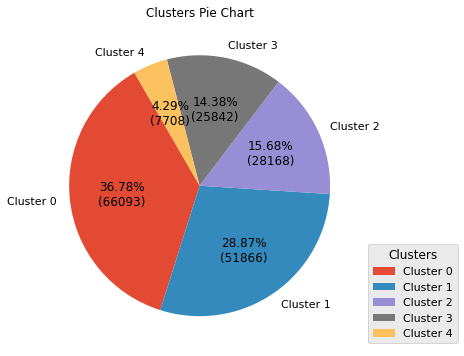

In [260]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f'{pct :.2f}%\n({absolute :d})'

ax.set_title('Clusters Pie Chart')
labels = ['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3','Cluster 4']
ax.pie(df_rfm_k5.Cluster.value_counts(),
        labels = labels,
        autopct=lambda pct: func(pct, df_rfm_k5.Cluster.value_counts()),
        textprops=dict(color='k'), startangle=120
        )
ax.legend(title='Clusters',
          loc='lower left',
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [271]:
cluster_results = pd.concat([
                        df_rfm_k5.groupby('Cluster').mean().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster').median().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster').max().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster').min().drop(columns='CustomerID')
                        ], 
                        keys=['mean', 'median', 'max', 'min'],
                        axis=1)
cluster_results

mean                     median                        max  \
        Recency Frequency Monetary Recency Frequency Monetary Recency   
Cluster                                                                 
0            81         7    57070      68         5    33295     378   
1           161         1      991     163         1      780     382   
2           261         1     6264     264         1     5467     395   
3           121         2    12359     113         2    10840     388   
4            99         1     7389     102         1     5834     195   

                               min                     
        Frequency Monetary Recency Frequency Monetary  
Cluster                                                
0             231  3360683       0         3     3543  
1               3     2640       1         1      106  
2               3    97560     176         1      760  
3               5   108550       0         2      941  
4               1   175200       0         1     1320

In [312]:
# def pointplot(df, metric):
#     '''
#     '''
#     data = df.groupby('Cluster', as_index=False).describe()
#     # data = data[[metric]].describe().drop(columns=[(metric, 'count'), (metric, 'std')])
#     # x = data[[metric]].describe().columns
#     print(data)
#     # y = data[[metric]].describe()[(metric, *[j for j in [i for i in x]])]
#     # sns.pointplot(data=data, x=x, y=y, hue='Cluster')
#     # plt.title(f'{metric} by Cluster')
#     # plt.xlabel(metric)
#     # plt.ylabel('Cluster')
#     # plt.show()
    
# pointplot(df_rfm_k5, 'Recency')


cluster_results = pd.concat([
                        df_rfm_k5.groupby('Cluster', as_index=False).mean().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster', as_index=False).median().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster', as_index=False).max().drop(columns='CustomerID'),
                        df_rfm_k5.groupby('Cluster', as_index=False).min().drop(columns='CustomerID')
                        ], 
                        keys=['mean', 'median', 'max', 'min'],
                        axis=1)
cluster_results

mean                             median                             \
  Cluster Recency Frequency Monetary Cluster Recency Frequency Monetary   
0       0      81         7    57070       0      68         5    33295   
1       1     161         1      991       1     163         1      780   
2       2     261         1     6264       2     264         1     5467   
3       3     121         2    12359       3     113         2    10840   
4       4      99         1     7389       4     102         1     5834   

      max                                min                             
  Cluster Recency Frequency Monetary Cluster Recency Frequency Monetary  
0       0     378       231  3360683       0       0         3     3543  
1       1     382         3     2640       1       1         1      106  
2       2     395         3    97560       2     176         1      760  
3       3     388         5   108550       3       0         2      941  
4       4     195         1   175200       4       0         1     1320

In [315]:
data = df_rfm_k5.groupby('Cluster', as_index=False)
data[['Recency']].describe().drop(columns=[('Recency', 'count'), ('Recency', 'std')])[('Recency', 'mean')]


0    81
1   161
2   261
3   121
4    99
Name: (Recency, mean), dtype: float64

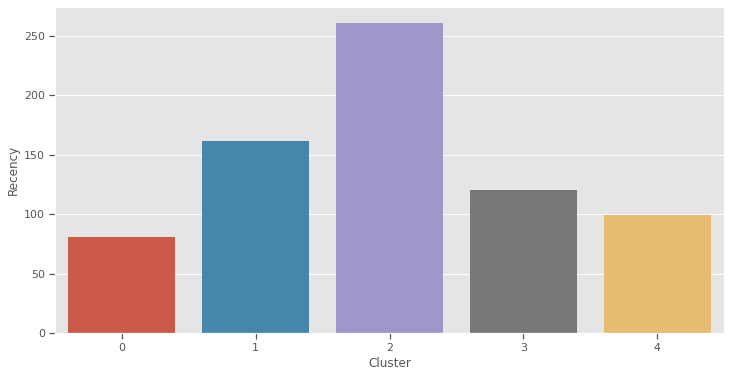

In [318]:
sns.barplot(x='Cluster', y='Recency', data=data.mean())
plt.show()
# sns.barplot(x='Cluster', y='Recency', data=data.median())
# sns.barplot(x='Cluster', y='Recency', data=data.max())
# sns.barplot(x='Cluster', y='Recency', data=data.min())

## task 4
Calculate CLV for customers who have been joined in Farvardin. (Assume that each
customer's join date is the same as the date of their first order) (Bonus Question)


CLV = ARPU (Average Revenue per User)/ChurnRate

In [98]:
# customer's join date is the same as the date of their first order
customer_groupby = revenue.groupby(['CustomerID'],as_index=False)
customer_join_date = customer_groupby[['JdDate']].min()

In [243]:
far_joined_customers = customer_join_date[(customer_join_date.JdDate < jd.date(1398, 2, 1))\
                    | (customer_join_date.JdDate >= jd.date(1399, 1, 1))].sort_values(by='JdDate').reset_index()

In [111]:
recency_ = customer_groupby['JdDate'].max().rename(columns={'JdDate': 'LastPurchaseDate'})
recency_['Recency'] = recency_.LastPurchaseDate.apply(lambda x:(LASTJDATE - x).days)
recency_['ChurnCustomer']= recency_.Recency.apply(lambda x:1 if x > 365 else 0)
recency_.drop(columns=['LastPurchaseDate'], inplace=True)

arpu_far = far_joined_customers.merge(customer_groupby.Revenue.mean(), on='CustomerID', how='left')
arpu_far.rename(columns={'Revenue':'AvgRevenue', 'JdDate':'JoinedDate'}, inplace=True)
arpu_far.drop(columns=['index'], inplace=True)

arpu_far_churn = arpu_far.merge(recency_, on='CustomerID', how='left')

In [128]:
CHURN_RATE = recency_.ChurnCustomer.sum()/ recency_.shape[0] * 100

In [130]:
arpu_far_churn['CLV'] = arpu_far_churn.AvgRevenue / CHURN_RATE

In [129]:
CHURN_RATE

1.1603962600178093

In [131]:
arpu_far_churn

,CustomerID,JoinedDate,AvgRevenue,Recency,ChurnCustomer,CLV
0,11229102,1398-01-01,5100,395,1,4395
1,11253293,1398-01-01,5100,395,1,4395
2,11253082,1398-01-01,6969,382,1,6006
3,11252738,1398-01-01,11706,395,1,10088
4,11253779,1398-01-01,5100,395,1,4395


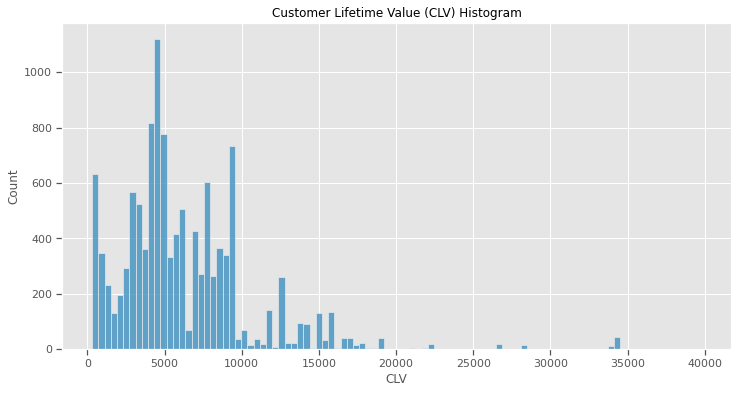

In [136]:
plt.title('Customer Lifetime Value (CLV) Histogram')
sns.histplot(data=arpu_far_churn, x='CLV')
plt.show()

,CustomerID,JoinedDate,AvgRevenue,Recency,ChurnCustomer,CLV
0,11229102,1398-01-01,5100,395,1,4395
1,11253293,1398-01-01,5100,395,1,4395
2,11253082,1398-01-01,6969,382,1,6006
3,11252738,1398-01-01,11706,395,1,10088
4,11253779,1398-01-01,5100,395,1,4395
